In [ ]:
%pip install pandas numpy matplotlib seaborn scikit-learn nltk spacy
%python -m spacy download en_core_web_sm

UsageError: Line magic function `%python` not found (But cell magic `%%python` exists, did you mean that instead?).


In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load Spacy English model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Downloading 'en_core_web_sm' model for Spacy as it was not found.")
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load('en_core_web_sm')


/Users/push/pro/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/push/pro/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# Function to Load Data
def load_data():
    """
    Load datasets from CSV files.

    Returns:
        calls (DataFrame): Data from calls.csv
        customers (DataFrame): Data from customers.csv
        reasons (DataFrame): Data from reason.csv
        sentiments (DataFrame): Data from sentiment_statistics.csv
        test (DataFrame): Data from test.csv (optional)
    """
    try:
        calls = pd.read_csv('calls.csv')
        customers = pd.read_csv('customers.csv')
        reasons = pd.read_csv('reason.csv')
        sentiments = pd.read_csv('sentiment_statistics.csv')
        test = pd.read_csv('test.csv')
        print("All datasets loaded successfully.\n")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure all required CSV files are in the same directory as this notebook.")
        exit()
    return calls, customers, reasons, sentiments, test

# Load the data
calls, customers, reasons, sentiments, test = load_data()


All datasets loaded successfully.



In [ ]:
# Function to Merge Data
def merge_data(calls, customers, reasons, sentiments):
    """
    Merge datasets into a single DataFrame.

    Args:
        calls (DataFrame): Calls data.
        customers (DataFrame): Customers data.
        reasons (DataFrame): Call reasons data.
        sentiments (DataFrame): Sentiment statistics data.

    Returns:
        data (DataFrame): Merged DataFrame.
    """
    # Merge calls with customers on 'customer_id'
    data = pd.merge(calls, customers, on='customer_id', how='left')

    # Merge with reasons on 'call_id'
    data = pd.merge(data, reasons, on='call_id', how='left')

    # Merge with sentiments on 'call_id' and 'agent_id'
    data = pd.merge(data, sentiments, on=['call_id', 'agent_id'], how='left')

    print("Datasets merged successfully. Sample data:")
    display(data.head())
    return data

# Merge the data
data = merge_data(calls, customers, reasons, sentiments)


Datasets merged successfully. Sample data:


,call_id,customer_id,agent_id,call_start_datetime,agent_assigned_datetime,call_end_datetime,call_transcript,customer_name,elite_level_code,primary_call_reason,agent_tone,customer_tone,average_sentiment,silence_percent_average
0,4667960400,2033123310,963118,7/31/2024 23:56,8/1/2024 0:03,8/1/2024 0:34,\n\nAgent: Thank you for calling United Airlin...,Matthew Foster,4.0,Voluntary Cancel,neutral,angry,-0.04,0.39
1,1122072124,8186702651,519057,8/1/2024 0:03,8/1/2024 0:06,8/1/2024 0:18,\n\nAgent: Thank you for calling United Airlin...,Tammy Walters,NaN,Booking,calm,neutral,0.02,0.35
2,6834291559,2416856629,158319,7/31/2024 23:59,8/1/2024 0:07,8/1/2024 0:26,\n\nAgent: Thank you for calling United Airlin...,Jeffery Dixon,NaN,IRROPS,neutral,polite,-0.13,0.32
3,2266439882,1154544516,488324,8/1/2024 0:05,8/1/2024 0:10,8/1/2024 0:17,\n\nAgent: Thank you for calling United Airlin...,David Wilkins,2.0,Upgrade,neutral,frustrated,-0.20,0.20
4,1211603231,5214456437,721730,8/1/2024 0:04,8/1/2024 0:14,8/1/2024 0:23,\n\nAgent: Thank you for calling United Airlin...,Elizabeth Daniels,0.0,Seating,neutral,polite,-0.05,0.35


In [ ]:
# Function to Preprocess Data
def preprocess_data(data):
    """
    Preprocess the merged data:
    - Convert datetime columns to datetime objects.
    - Calculate AHT and AST.
    - Handle missing values.

    Args:
        data (DataFrame): Merged DataFrame.

    Returns:
        data (DataFrame): Preprocessed DataFrame.
    """
    # Convert datetime columns to datetime objects
    datetime_cols = ['call_start_datetime', 'agent_assigned_datetime', 'call_end_datetime']
    for col in datetime_cols:
        data[col] = pd.to_datetime(data[col], errors='coerce')

    # Calculate AHT (Average Handle Time) in seconds
    data['AHT'] = (data['call_end_datetime'] - data['agent_assigned_datetime']).dt.total_seconds()

    # Calculate AST (Average Speed to Answer) in seconds
    data['AST'] = (data['agent_assigned_datetime'] - data['call_start_datetime']).dt.total_seconds()

    # Handle missing values
    # For 'elite_level_code', replace NaN with 0
    data['elite_level_code'].fillna(0, inplace=True)

    # For 'agent_tone' and 'customer_tone', replace NaN with 'neutral'
    data['agent_tone'].fillna('neutral', inplace=True)
    data['customer_tone'].fillna('neutral', inplace=True)

    # For numerical fields, replace NaN with 0
    data['average_sentiment'].fillna(0, inplace=True)
    data['silence_percent_average'].fillna(0, inplace=True)

    # For 'primary_call_reason', replace NaN with 'Unknown'
    data['primary_call_reason'].fillna('Unknown', inplace=True)

    # Verify missing values are handled
    print("Missing values after handling:")
    print(data.isnull().sum(), "\n")

    return data

# Preprocess the data
data = preprocess_data(data)


Missing values after handling:
call_id                    0
customer_id                0
agent_id                   0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
customer_name              0
elite_level_code           0
primary_call_reason        0
agent_tone                 0
customer_tone              0
average_sentiment          0
silence_percent_average    0
AHT                        0
AST                        0
dtype: int64 



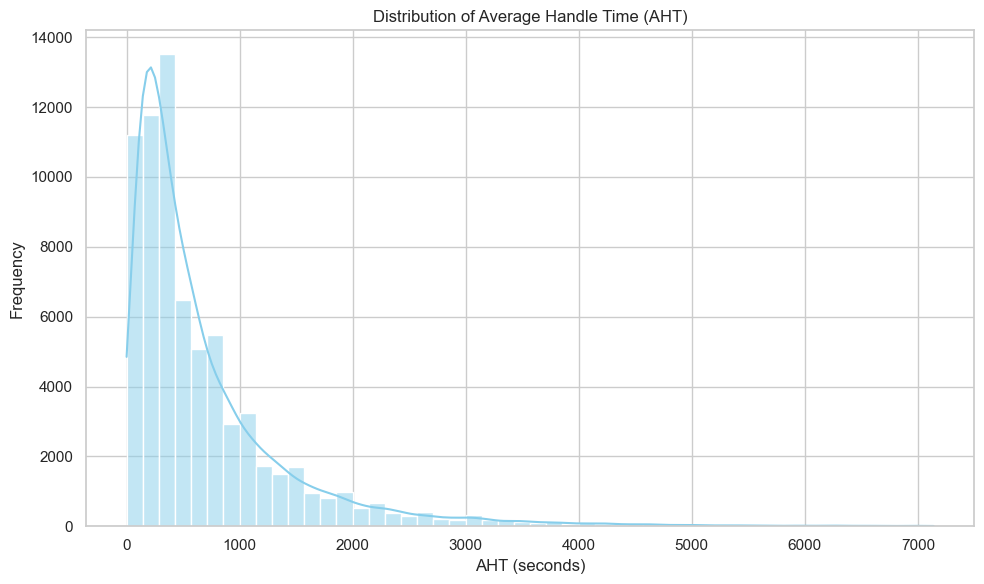

In [ ]:
# Setting the plot style
sns.set(style='whitegrid')

# Distribution of AHT
plt.figure(figsize=(10,6))
sns.histplot(data['AHT'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Average Handle Time (AHT)')
plt.xlabel('AHT (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


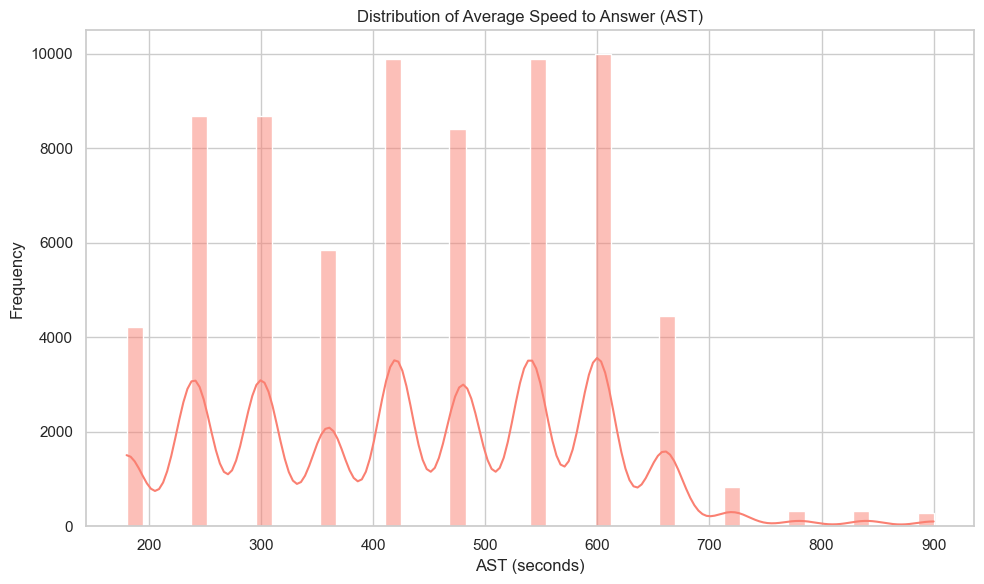

In [ ]:
# Distribution of AST
plt.figure(figsize=(10,6))
sns.histplot(data['AST'], bins=50, kde=True, color='salmon')
plt.title('Distribution of Average Speed to Answer (AST)')
plt.xlabel('AST (seconds)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


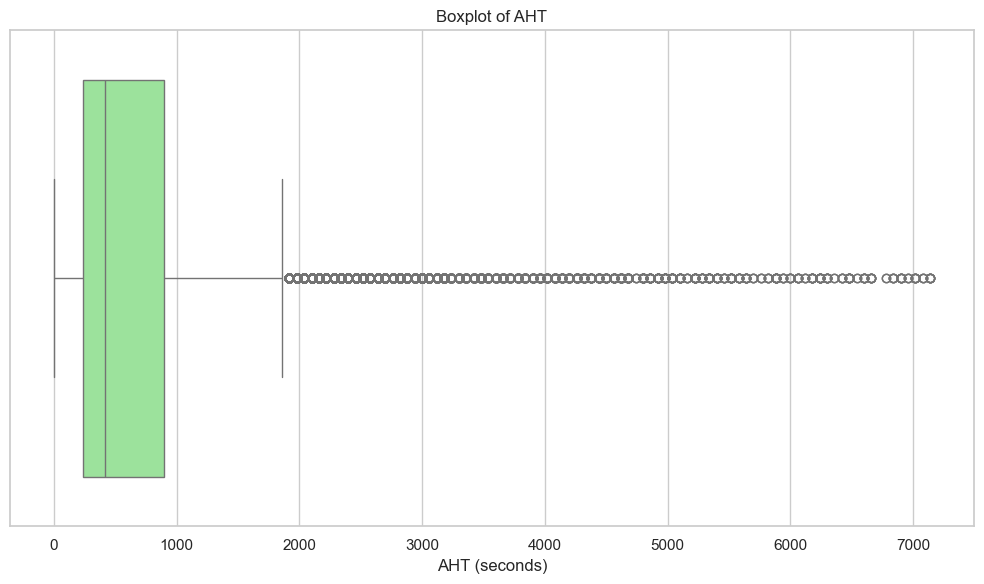

In [ ]:
# Boxplot for AHT
plt.figure(figsize=(10,6))
sns.boxplot(x=data['AHT'], color='lightgreen')
plt.title('Boxplot of AHT')
plt.xlabel('AHT (seconds)')
plt.tight_layout()
plt.show()


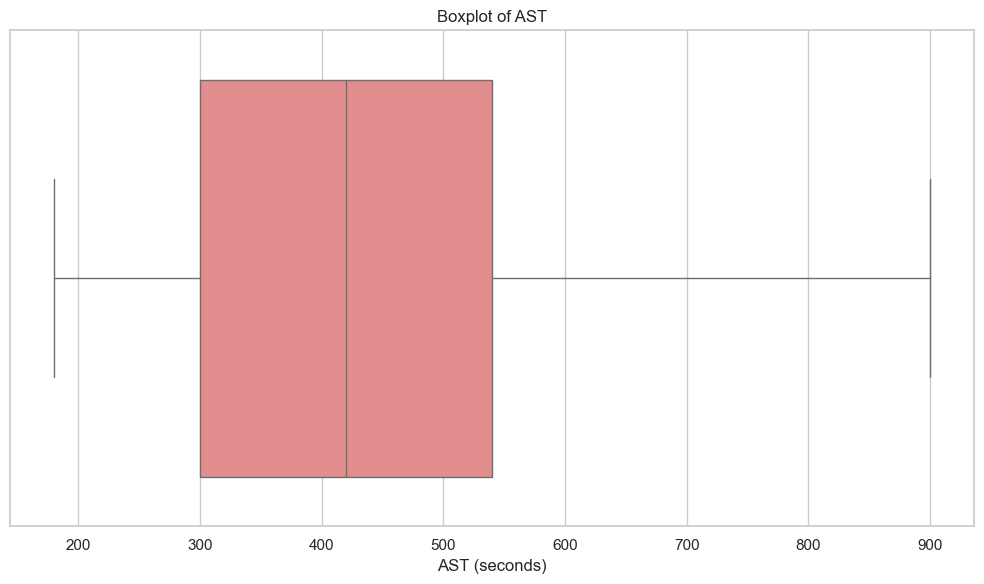

In [ ]:
# Boxplot for AST
plt.figure(figsize=(10,6))
sns.boxplot(x=data['AST'], color='lightcoral')
plt.title('Boxplot of AST')
plt.xlabel('AST (seconds)')
plt.tight_layout()
plt.show()


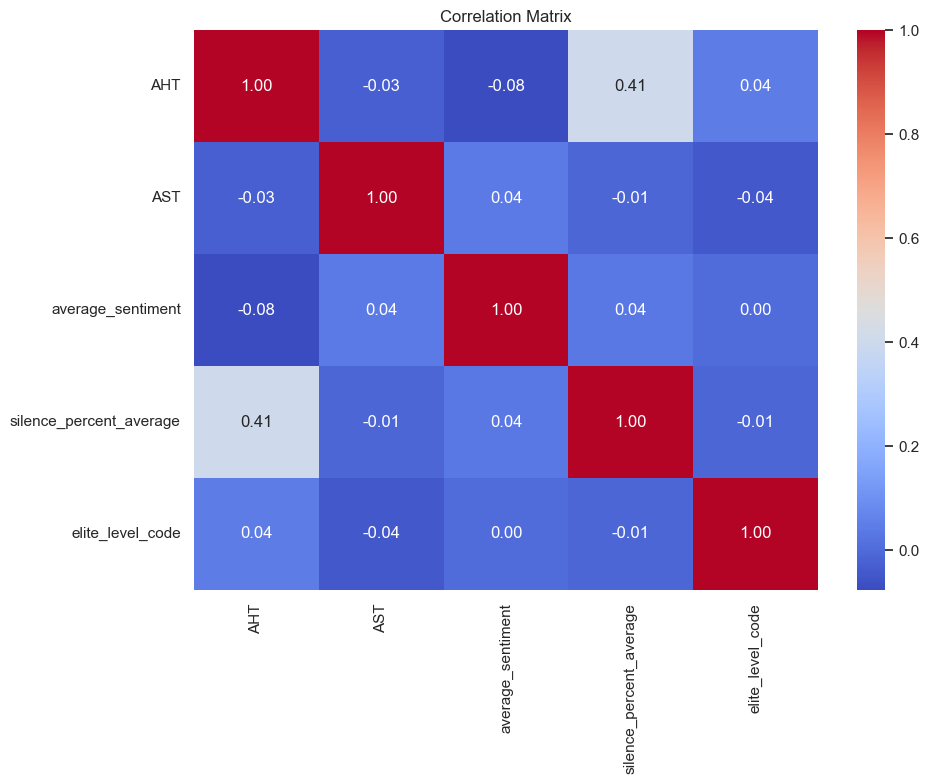

In [ ]:
# Correlation Matrix
plt.figure(figsize=(10,8))
corr = data[['AHT', 'AST', 'average_sentiment', 'silence_percent_average', 'elite_level_code']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


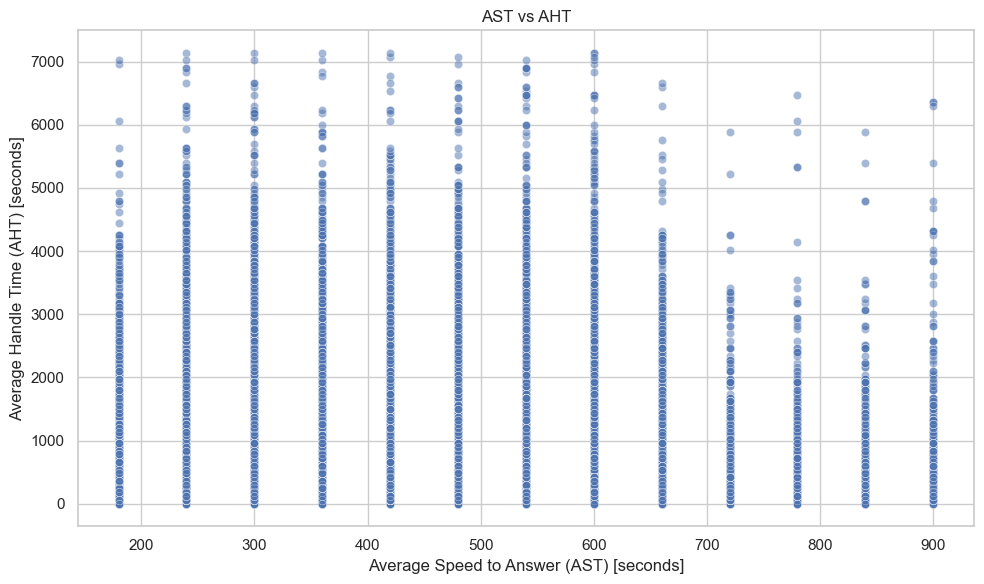

In [ ]:
# Scatter plot of AST vs AHT
plt.figure(figsize=(10,6))
sns.scatterplot(x='AST', y='AHT', data=data, alpha=0.5)
plt.title('AST vs AHT')
plt.xlabel('Average Speed to Answer (AST) [seconds]')
plt.ylabel('Average Handle Time (AHT) [seconds]')
plt.tight_layout()
plt.show()


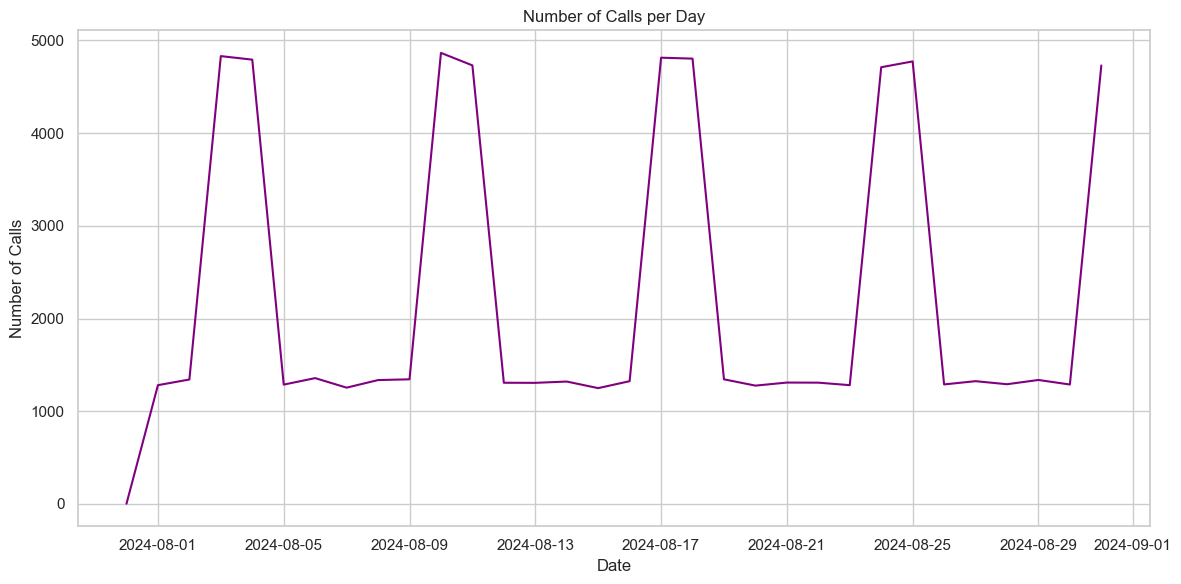

In [ ]:
# Time Series Analysis: Calls per Day
data['call_date'] = data['call_start_datetime'].dt.date
calls_per_day = data.groupby('call_date').size()

plt.figure(figsize=(12,6))
calls_per_day.plot(kind='line', color='purple')
plt.title('Number of Calls per Day')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.tight_layout()
plt.show()


In [ ]:
# Selecting relevant features
features = ['AST', 'average_sentiment', 'silence_percent_average', 'elite_level_code']
target_aht = 'AHT'
target_ast = 'AST'

# Correlation with AHT
print("Correlation of Features with AHT:")
print(data[features + [target_aht]].corr()[target_aht].sort_values(ascending=False), "\n")

# Correlation with AST
print("Correlation of Features with AST:")
print(data[features].corr()[target_ast].sort_values(ascending=False), "\n")

Correlation of Features with AHT:
AHT                        1.000000
silence_percent_average    0.406883
elite_level_code           0.043911
AST                       -0.027778
average_sentiment         -0.076117
Name: AHT, dtype: float64 

Correlation of Features with AST:
AST                        1.000000
average_sentiment          0.039888
silence_percent_average   -0.012068
elite_level_code          -0.043266
Name: AST, dtype: float64 



In [ ]:
# Regression Analysis for AHT
X_aht = data[features]
y_aht = data[target_aht]

# Split data into training and testing sets
X_aht_train, X_aht_test, y_aht_train, y_aht_test = train_test_split(X_aht, y_aht, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
lr_aht = LinearRegression()
lr_aht.fit(X_aht_train, y_aht_train)

# Predict on test set
y_aht_pred = lr_aht.predict(X_aht_test)

# Evaluate the model
mae_aht = mean_absolute_error(y_aht_test, y_aht_pred)
print(f"Mean Absolute Error for AHT Prediction: {mae_aht:.2f} seconds\n")

# Feature Importance for AHT
coef_aht = pd.Series(lr_aht.coef_, index=features).sort_values(ascending=False)
print("Feature Coefficients for AHT Prediction:")
print(coef_aht, "\n")


Mean Absolute Error for AHT Prediction: 452.75 seconds

Feature Coefficients for AHT Prediction:
silence_percent_average    1645.952851
elite_level_code             27.949908
AST                          -0.088823
average_sentiment          -483.722113
dtype: float64 



In [ ]:
# Regression Analysis for AST
X_ast = data[features]
y_ast = data[target_ast]

# Split data into training and testing sets
X_ast_train, X_ast_test, y_ast_train, y_ast_test = train_test_split(X_ast, y_ast, test_size=0.2, random_state=42)

# Initialize and train Linear Regression model
lr_ast = LinearRegression()
lr_ast.fit(X_ast_train, y_ast_train)

# Predict on test set
y_ast_pred = lr_ast.predict(X_ast_test)

# Evaluate the model
mae_ast = mean_absolute_error(y_ast_test, y_ast_pred)
print(f"Mean Absolute Error for AST Prediction: {mae_ast:.2f} seconds\n")

# Feature Importance for AST
coef_ast = pd.Series(lr_ast.coef_, index=features).sort_values(ascending=False)
print("Feature Coefficients for AST Prediction:")
print(coef_ast, "\n")


Mean Absolute Error for AST Prediction: 0.00 seconds

Feature Coefficients for AST Prediction:
AST                        1.000000e+00
average_sentiment          9.533757e-13
elite_level_code          -7.978001e-14
silence_percent_average   -3.751318e-13
dtype: float64 



In [ ]:
# Frequency Analysis of Primary Call Reasons
call_reason_counts = data['primary_call_reason'].value_counts()
print("Call Reason Frequencies:")
print(call_reason_counts, "\n")


Call Reason Frequencies:
primary_call_reason
IRROPS                     13057
Voluntary Change           10291
Seating                     6223
Mileage Plus                5487
Unknown                     5157
Post-Flight                 3869
Communications              3779
Products and Services       2792
Upgrade                     2682
Baggage                     2616
Booking                     2589
Checkout                    1840
Check-In                    1490
Voluntary Cancel            1304
Digital Support              996
ETC                          930
Traveler Updates             772
Schedule Change              707
Other Topics                 568
Products & Services          476
Disability                   394
Check In                     385
Post Flight                  373
Voluntary  Cancel            278
IRROPS                       254
Other  Topics                234
Voluntary Change             208
Voluntary   Change           200
Voluntary  Change            14

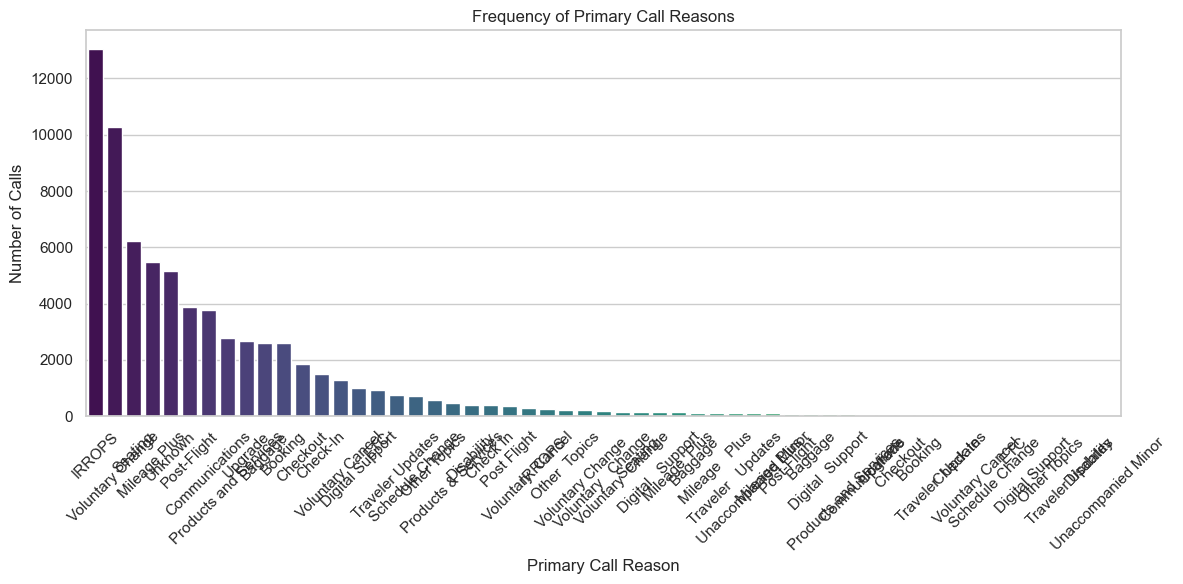

In [ ]:
# Plotting Call Reason Frequencies
plt.figure(figsize=(12,6))
sns.barplot(x=call_reason_counts.index, y=call_reason_counts.values, palette='viridis')
plt.title('Frequency of Primary Call Reasons')
plt.xlabel('Primary Call Reason')
plt.ylabel('Number of Calls')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Percentage Difference between Most and Least Frequent Call Reasons
most_freq = call_reason_counts.max()
least_freq = call_reason_counts.min()
percentage_diff = ((most_freq - least_freq) / most_freq) * 100
print(f"Percentage difference between most and least frequent call reasons: {percentage_diff:.2f}%\n")


Percentage difference between most and least frequent call reasons: 99.99%



In [ ]:
# Top 10 and Bottom 10 Call Reasons
top_10_reasons = call_reason_counts.head(10)
bottom_10_reasons = call_reason_counts.tail(10)

print("Top 10 Call Reasons:")
print(top_10_reasons, "\n")

print("Bottom 10 Call Reasons:")
print(bottom_10_reasons, "\n")


Top 10 Call Reasons:
primary_call_reason
IRROPS                   13057
Voluntary Change         10291
Seating                   6223
Mileage Plus              5487
Unknown                   5157
Post-Flight               3869
Communications            3779
Products and Services     2792
Upgrade                   2682
Baggage                   2616
Name: count, dtype: int64 

Bottom 10 Call Reasons:
primary_call_reason
Traveler  Updates        38
Check-In                 29
Voluntary Cancel         25
Schedule Change          24
ETC                      22
Digital Support          18
Other Topics             16
Traveler Updates         10
Disability                9
Unaccompanied Minor       1
Name: count, dtype: int64 



In [ ]:
# Function to Preprocess a Single Transcript
def preprocess_transcript(text):
    """
    Preprocess a single call transcript:
    - Lowercasing
    - Lemmatization
    - Removing stop words and non-alphabetic tokens

    Args:
        text (str): Raw call transcript.

    Returns:
        processed_text (str): Preprocessed transcript.
    """
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)


In [ ]:
# ... existing code ...

# Import necessary libraries
import swifter
from tqdm.auto import tqdm

# Enable progress bar for swifter
swifter.set_defaults(progress_bar=True)

# Function to Preprocess a Single Transcript (optimized)
def preprocess_transcript(text):
    """
    Preprocess a single call transcript:
    - Lowercasing
    - Lemmatization
    - Removing stop words and non-alphabetic tokens

    Args:
        text (str): Raw call transcript.

    Returns:
        processed_text (str): Preprocessed transcript.
    """
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# Preprocess Call Transcripts (optimized with progress bar)
print("Preprocessing call transcripts...")
tqdm.pandas(desc="Processing")
data['call_transcript_processed'] = data['call_transcript'].progress_apply(preprocess_transcript)
print("Sample processed transcripts:")
display(data[['call_transcript', 'call_transcript_processed']].head())

# ... existing code ...

In [ ]:
# Vectorization using CountVectorizer
print("Vectorizing call transcripts...")
vectorizer = CountVectorizer(max_features=1000)
X_transcripts = vectorizer.fit_transform(data['call_transcript_processed'])
transcript_df = pd.DataFrame(X_transcripts.toarray(), columns=vectorizer.get_feature_names_out())


In [ ]:
# Identifying keywords associated with high AHT and AST

# Define thresholds (95th percentile) for high AHT and AST
high_aht_threshold = data['AHT'].quantile(0.95)
high_ast_threshold = data['AST'].quantile(0.95)

# Identify high AHT and AST calls
high_aht_calls = data[data['AHT'] > high_aht_threshold]
high_ast_calls = data[data['AST'] > high_ast_threshold]

# Sum word counts in high AHT calls
high_aht_words = transcript_df.loc[high_aht_calls.index].sum().sort_values(ascending=False).head(20)
print("Top 20 Words in High AHT Calls:")
print(high_aht_words, "\n")

# Sum word counts in high AST calls
high_ast_words = transcript_df.loc[high_ast_calls.index].sum().sort_values(ascending=False).head(20)
print("Top 20 Words in High AST Calls:")
print(high_ast_words, "\n")


In [ ]:
# Function to Plot Top Words
def plot_top_words(word_series, title):
    """
    Plot the top words in a given series.

    Args:
        word_series (Series): Series containing word counts.
        title (str): Title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(12,6))
    sns.barplot(x=word_series.values, y=word_series.index, palette='magma')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

# Plot Top Words in High AHT Calls
plot_top_words(high_aht_words, 'Top 20 Words in High AHT Calls')

# Plot Top Words in High AST Calls
plot_top_words(high_ast_words, 'Top 20 Words in High AST Calls')


In [ ]:
# Visualizing the proportion of self-solvable calls
plt.figure(figsize=(8,6))
sns.countplot(x=(data['self_solvable'] > 0), palette='Set2')
plt.title('Proportion of Self-Solvable vs. Non-Self-Solvable Calls')
plt.xlabel('Self-Solvable Call')
plt.ylabel('Number of Calls')
plt.xticks([0,1], ['No', 'Yes'])
plt.tight_layout()
plt.show()


In [ ]:
# Encoding the target variable
le = LabelEncoder()
data['primary_call_reason_encoded'] = le.fit_transform(data['primary_call_reason'])
# Features and target for modeling
X_reason = transcript_df
y_reason = data['primary_call_reason_encoded']

# Split data into training and testing sets
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reason, y_reason, test_size=0.2, random_state=42)
# Initialize and train Random Forest Classifier
print("Training Random Forest Classifier for Primary Call Reason Prediction...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_r, y_train_r)


In [ ]:
# Predict on test set
y_pred_r = clf.predict(X_test_r)

# Evaluate the model
print("\nClassification Report for Primary Call Reason Prediction:")
print(classification_report(y_test_r, y_pred_r, target_names=le.classes_))


In [ ]:
# Preprocess test transcripts
print("Preprocessing test transcripts...")
test['call_transcript_processed'] = test['call_transcript'].apply(preprocess_transcript)
print("Sample processed test transcripts:")
display(test[['call_id', 'call_transcript', 'call_transcript_processed']].head())
# Vectorize test transcripts using the same vectorizer
print("Vectorizing test transcripts...")
X_test_transcripts = vectorizer.transform(test['call_transcript_processed'])
test_transcript_df = pd.DataFrame(X_test_transcripts.toarray(), columns=vectorizer.get_feature_names_out())
# Prepare submission file
submission = test[['call_id', 'primary_call_reason']]
submission.to_csv('test_predictions.csv', index=False)
print("Predictions for test data have been saved to 'test_predictions.csv'.\n")


In [ ]:
# Vectorize test transcripts using the same vectorizer
print("Vectorizing test transcripts...")
X_test_transcripts = vectorizer.transform(test['call_transcript_processed'])
test_transcript_df = pd.DataFrame(X_test_transcripts.toarray(), columns=vectorizer.get_feature_names_out())
# Prepare submission file
submission = test[['call_id', 'primary_call_reason']]
submission.to_csv('test_predictions.csv', index=False)
print("Predictions for test data have been saved to 'test_predictions.csv'.\n")
